# STFT with Convolution NN

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from glob import glob
import pickle
import tensorflow
from scipy import stats

In [2]:
#Path to the dataset 
FOLDER_PATH = 'data/'
#get all files within the path
files_list = sorted(glob(FOLDER_PATH + '*'))   
print(files_list)

['data\\s01.dat', 'data\\s02.dat', 'data\\s03.dat', 'data\\s04.dat', 'data\\s05.dat', 'data\\s06.dat', 'data\\s07.dat', 'data\\s08.dat', 'data\\s09.dat', 'data\\s10.dat', 'data\\s11.dat', 'data\\s12.dat', 'data\\s13.dat', 'data\\s14.dat', 'data\\s15.dat', 'data\\s16.dat', 'data\\s17.dat', 'data\\s18.dat', 'data\\s19.dat', 'data\\s20.dat', 'data\\s21.dat', 'data\\s22.dat', 'data\\s23.dat', 'data\\s24.dat', 'data\\s25.dat', 'data\\s26.dat', 'data\\s27.dat', 'data\\s28.dat', 'data\\s29.dat', 'data\\s30.dat', 'data\\s31.dat', 'data\\s32.dat']


In [3]:

#Original shape of DEAP dataset 32 = participants, 40 = clips / person, 40 = channels, 8064 = signals each 
#total samples of 8064 * 1280 = 10,321,920
org_data = np.zeros((32,40,40,8064))

#Original shape of the labels 32 = participants, 40 = clips, 4 = targets = Valence, Arousal, Dominance, Likeness
org_labels = np.zeros((32,40,4))

for i, f in (enumerate(tqdm(files_list))):
      with open(f, 'rb') as f: 
        content = pickle.load(f, encoding='iso-8859-1')
        data = content['data']
        labels = content['labels'] 
        org_data[i] = data
        org_labels[i] = labels
        

100%|██████████| 32/32 [00:06<00:00,  4.57it/s]


In [4]:
print(f"Original Shape of the data: {org_data.shape}")
print(f"Original Shape of the labels:{org_labels.shape}")

Original Shape of the data: (32, 40, 40, 8064)
Original Shape of the labels:(32, 40, 4)


In [5]:
signals = ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2', 'hEOG (horizontal EOG, hEOG1 - hEOG2)', 'vEOG (vertical EOG, vEOG1 - vEOG2)', 'zEMG (Zygomaticus Major EMG, zEMG1 - zEMG2)', 'tEMG (Trapezius EMG, tEMG1 - tEMG2)', 'GSR (values from Twente converted to Geneva format (Ohm))', 'Respiration belt', 'Plethysmograph', 'Temperature']
eeg_signals = signals[:32]
phy_signals = signals[32:]
labels = ['valence', 'arousal', 'dominance', 'liking']

print(f"EEG signals: {eeg_signals}")
print(f"Physiological signals : {phy_signals}")

EEG signals: ['Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1', 'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4', 'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8', 'PO4', 'O2']
Physiological signals : ['hEOG (horizontal EOG, hEOG1 - hEOG2)', 'vEOG (vertical EOG, vEOG1 - vEOG2)', 'zEMG (Zygomaticus Major EMG, zEMG1 - zEMG2)', 'tEMG (Trapezius EMG, tEMG1 - tEMG2)', 'GSR (values from Twente converted to Geneva format (Ohm))', 'Respiration belt', 'Plethysmograph', 'Temperature']


In [6]:
#Combining clips / person we get 32 * 40 = 1280 
eeg_data = org_data.reshape(-1, 40, 8064)
#Also taking only 32 channels as 32 are EEG signals and 8 are physiological signals
eeg_data = eeg_data[:,:32,:]

print(f"Proper EEG data shape: {eeg_data.shape}")

Proper EEG data shape: (1280, 32, 8064)


In [7]:
#Reshaping the labels data to 1280, 4
eeg_labels = org_labels.reshape(-1, 4)
print("EEG Labels shape: " , eeg_labels.shape)

EEG Labels shape:  (1280, 4)


In [8]:
from scipy import signal
from scipy.signal import welch
from scipy.integrate import simps
from scipy.stats import f_oneway
from mne import time_frequency

In [9]:
# Transforming the data using the Short Term Fourier Transform
stft_data = np.zeros([1280, 32, 65, 126])
for i in tqdm(range(eeg_data.shape[0])):
    stft = time_frequency.stft(eeg_data[i], wsize=128, verbose=False);
#     de = []
#     for j in stft:
#         de.append(stats.differential_entropy(j))
#     de = np.array(de)  
    stft_data[i] = stft  


  0%|          | 0/1280 [00:00<?, ?it/s]C:\Users\Amanda\AppData\Local\Temp/ipykernel_18396/1889107556.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  stft_data[i] = stft #Taking only the positive frequencies
100%|██████████| 1280/1280 [00:14<00:00, 90.23it/s]


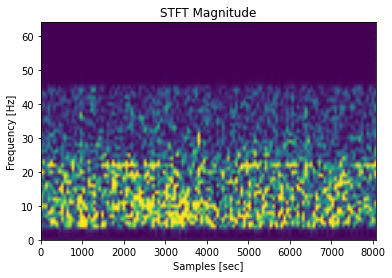

In [10]:
viz_data = stft_data[0]

plt.pcolormesh(np.linspace(0, 8064 , num= viz_data.shape[2]),
               np.linspace(0, 64 , num= viz_data.shape[1]),
               np.abs(viz_data[0])
               ,vmin=0, 
               vmax=4, 
               shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Samples [sec]')
plt.show()

In [11]:
stft_data.shape

(1280, 32, 65, 126)

In [12]:
eeg_labels.shape

(1280, 4)

In [13]:
lbl_valence = eeg_labels[:, 0]
lbl_arousal = eeg_labels[:, 1]

print("Valence y shape:" , lbl_valence.shape)
print("Arousal y shape:" , lbl_arousal.shape)


Valence y shape: (1280,)
Arousal y shape: (1280,)


In [14]:
#Binarizing the labels
lbl_val_bin = np.where(lbl_valence > 5, 1, 0) # 5 as a threshold 
lbl_ar_bin = np.where(lbl_arousal > 5, 1, 0)

print("Valence y binarized:" , lbl_val_bin)
print("Arousal y binarized:" , lbl_ar_bin)

Valence y binarized: [1 1 1 ... 0 0 1]
Arousal y binarized: [1 1 1 ... 1 1 0]


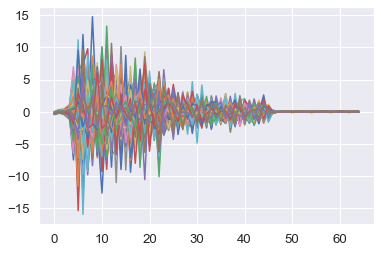

In [15]:
import seaborn as sns
sns.set(font_scale=1.2)
plt.plot(stft_data[0][0]);

In [16]:
n_samples = stft_data.shape[0]
n_channels = stft_data.shape[1]
n_classes = 2
num_freq = stft_data.shape[2]

batch_size = 100

In [17]:
import random
def split_data(X, y, test_size = 0.2):
    m = len(X)
    idx = np.arange(m)
    random.shuffle(idx)
    
    train_idx = idx[int(m * test_size):]
    test_idx = idx[len(train_idx):]
    
    X_train = X[train_idx, :]
    X_test = X[test_idx, :]
    y_train = y[train_idx]
    y_test = y[test_idx]
    
    return X_train, X_test, y_train, y_test

In [18]:
X_train, X_test, y_train, y_test =  split_data(stft_data, lbl_val_bin)

In [19]:
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (1024, 32, 65, 126)
X_test shape: (256, 32, 65, 126)
y_train shape: (1024,)
y_test shape: (256,)


In [20]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
import torch
# Creating tensor data for the network
def dataloader(X, y, batch):
    X_ = torch.tensor(X).float()
    y_ = torch.tensor(y).long()
    dataset_tensor = TensorDataset(X_, y_)
    return DataLoader(dataset_tensor, batch_size=batch_size, shuffle=True)

In [21]:
train_loader = dataloader(X_train, y_train, batch_size)
test_loader = dataloader(X_test, y_test, batch_size)

In [22]:
from torch import nn
import torch.nn.functional as F
padding  = 2
class CNN_(nn.Module):
    def __init__(self, num_classes = 2):
        super(CNN_, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(n_channels, 32, kernel_size=5, stride=1, padding= padding), 
            nn.BatchNorm2d(32),
            torch.nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size = 5, stride = 1, padding = padding),
            nn.BatchNorm2d(64),
            torch.nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(128),
            torch.nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.fc = nn.Linear(15360, num_classes)
        self.drop_out = nn.Dropout(p=0.2)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.drop_out(out)
        out = self.layer2(out)
        out = self.drop_out(out)
        out = self.layer3(out)
        out = self.drop_out(out)
        out = out.reshape(out.size(0), -1)   #can also use .view()
        out = self.fc(out)
        return out
        

In [23]:
#explicitly initialize weights for better learning
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, (nn.Conv2d, nn.Conv2d)):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.kaiming_normal_(param) #<---here

In [24]:
model = CNN_()
model.apply(initialize_weights)

CNN_(
  (layer1): Sequential(
    (0): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=15360, out_features=2, bias=True)
  (drop_out): Dropout(p=0.2, inplace=False)
)

In [25]:
learning_rate = 1e-5
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [26]:
def cnn_acc(preds,y):
    _, predicted = torch.max(preds.data, 1)
    correct = (predicted == y).sum()
    acc = correct / y.size(0)
    return acc

In [27]:
def train(model, loader, opt, crit):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for i, (features, label) in enumerate(loader): 
        #predict
        predictions = model(features)
        #calculate loss
        loss = criterion(predictions, label)
        acc = cnn_acc(predictions, label)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
                
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [28]:
def evaluate(model, loader, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    
    with torch.no_grad():
        for i, (features, label) in enumerate(loader):  

            predictions = model(features)
            
            loss = criterion(predictions, label)
            acc = cnn_acc(predictions, label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(loader), epoch_acc / len(loader)

In [29]:
num_epochs = 200
best_valid_loss = float('inf')

train_losses = []
train_acc_arr = []
test_losses = []
test_acc_arr = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, train_loader, optimizer, criterion)
    test_loss,test_acc = evaluate(model, test_loader, criterion)
     
    train_losses.append(train_loss)
    train_acc_arr.append(train_acc)
    test_losses.append(test_loss)
    test_acc_arr.append(test_acc)
    
    if test_loss < best_valid_loss:
        best_valid_loss = test_loss
        torch.save(model.state_dict(),'tensor.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%')

Epoch: 01 | Train Loss: 0.928 | Train Acc: 50.88%
	 Val. Loss: 0.781 |  Val. Acc: 56.19%
Epoch: 02 | Train Loss: 0.887 | Train Acc: 53.50%
	 Val. Loss: 0.721 |  Val. Acc: 59.90%
Epoch: 03 | Train Loss: 0.882 | Train Acc: 52.09%
	 Val. Loss: 0.723 |  Val. Acc: 53.74%
Epoch: 04 | Train Loss: 0.891 | Train Acc: 52.09%
	 Val. Loss: 0.715 |  Val. Acc: 54.24%
Epoch: 05 | Train Loss: 0.860 | Train Acc: 50.70%
	 Val. Loss: 0.715 |  Val. Acc: 54.05%
Epoch: 06 | Train Loss: 0.876 | Train Acc: 52.48%
	 Val. Loss: 0.698 |  Val. Acc: 54.45%
Epoch: 07 | Train Loss: 0.848 | Train Acc: 52.09%
	 Val. Loss: 0.701 |  Val. Acc: 54.26%
Epoch: 08 | Train Loss: 0.871 | Train Acc: 50.12%
	 Val. Loss: 0.697 |  Val. Acc: 56.76%
Epoch: 09 | Train Loss: 0.848 | Train Acc: 53.03%
	 Val. Loss: 0.688 |  Val. Acc: 58.95%
Epoch: 10 | Train Loss: 0.826 | Train Acc: 55.58%
	 Val. Loss: 0.690 |  Val. Acc: 59.93%
Epoch: 11 | Train Loss: 0.832 | Train Acc: 52.95%
	 Val. Loss: 0.684 |  Val. Acc: 55.71%
Epoch: 12 | Train Los

Epoch: 94 | Train Loss: 0.752 | Train Acc: 58.42%
	 Val. Loss: 0.595 |  Val. Acc: 74.93%
Epoch: 95 | Train Loss: 0.741 | Train Acc: 54.95%
	 Val. Loss: 0.594 |  Val. Acc: 72.62%
Epoch: 96 | Train Loss: 0.740 | Train Acc: 57.86%
	 Val. Loss: 0.595 |  Val. Acc: 76.45%
Epoch: 97 | Train Loss: 0.742 | Train Acc: 59.32%
	 Val. Loss: 0.592 |  Val. Acc: 72.74%
Epoch: 98 | Train Loss: 0.732 | Train Acc: 59.03%
	 Val. Loss: 0.590 |  Val. Acc: 73.52%
Epoch: 99 | Train Loss: 0.710 | Train Acc: 60.44%
	 Val. Loss: 0.589 |  Val. Acc: 74.86%
Epoch: 100 | Train Loss: 0.719 | Train Acc: 57.48%
	 Val. Loss: 0.593 |  Val. Acc: 73.48%
Epoch: 101 | Train Loss: 0.727 | Train Acc: 58.88%
	 Val. Loss: 0.591 |  Val. Acc: 73.93%
Epoch: 102 | Train Loss: 0.761 | Train Acc: 57.74%
	 Val. Loss: 0.592 |  Val. Acc: 71.95%
Epoch: 103 | Train Loss: 0.719 | Train Acc: 59.14%
	 Val. Loss: 0.585 |  Val. Acc: 75.45%
Epoch: 104 | Train Loss: 0.706 | Train Acc: 59.61%
	 Val. Loss: 0.596 |  Val. Acc: 72.21%
Epoch: 105 | Tra

Epoch: 186 | Train Loss: 0.668 | Train Acc: 60.11%
	 Val. Loss: 0.542 |  Val. Acc: 78.19%
Epoch: 187 | Train Loss: 0.699 | Train Acc: 61.36%
	 Val. Loss: 0.544 |  Val. Acc: 77.93%
Epoch: 188 | Train Loss: 0.691 | Train Acc: 61.15%
	 Val. Loss: 0.547 |  Val. Acc: 78.45%
Epoch: 189 | Train Loss: 0.699 | Train Acc: 60.14%
	 Val. Loss: 0.543 |  Val. Acc: 78.86%
Epoch: 190 | Train Loss: 0.682 | Train Acc: 58.88%
	 Val. Loss: 0.545 |  Val. Acc: 78.38%
Epoch: 191 | Train Loss: 0.658 | Train Acc: 60.79%
	 Val. Loss: 0.547 |  Val. Acc: 78.40%
Epoch: 192 | Train Loss: 0.662 | Train Acc: 61.59%
	 Val. Loss: 0.542 |  Val. Acc: 79.00%
Epoch: 193 | Train Loss: 0.681 | Train Acc: 59.83%
	 Val. Loss: 0.544 |  Val. Acc: 77.45%
Epoch: 194 | Train Loss: 0.651 | Train Acc: 60.73%
	 Val. Loss: 0.538 |  Val. Acc: 81.57%
Epoch: 195 | Train Loss: 0.663 | Train Acc: 63.06%
	 Val. Loss: 0.543 |  Val. Acc: 79.79%
Epoch: 196 | Train Loss: 0.671 | Train Acc: 62.95%
	 Val. Loss: 0.545 |  Val. Acc: 77.40%
Epoch: 197

Text(0.5, 1.0, 'Train and Test Loss of Valence')

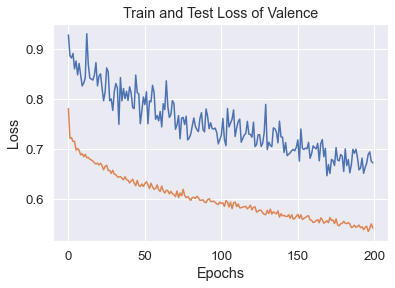

In [30]:
plt.plot(train_losses);
plt.plot(test_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Test Loss of Valence")

Text(0.5, 1.0, 'Train and Test Accuracy of Valence')

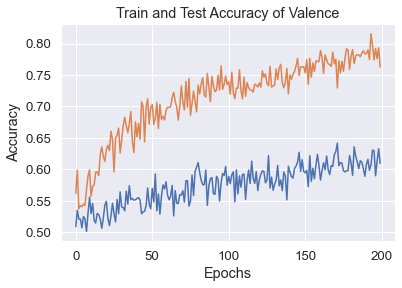

In [31]:
plt.plot(train_acc_arr);
plt.plot(test_acc_arr)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy of Valence")

In [32]:
torch.save(model.state_dict(),"./saves/STFT_CNN")

In [33]:
X_train_ar, X_test_ar, y_train_ar, y_test_ar =  split_data(stft_data, lbl_ar_bin)

In [34]:
train_loader_ar = dataloader(X_train_ar, y_train_ar, batch_size)
test_loader_ar = dataloader(X_test_ar, y_test_ar, batch_size)

In [35]:
num_epochs = 200
best_valid_loss = float('inf')

train_losses_ar = []
train_acc_arr_ar = []
test_losses_ar = []
test_acc_arr_ar = []
for epoch in range(num_epochs):

    train_loss,train_acc = train(model, train_loader_ar, optimizer, criterion)
    test_loss,test_acc = evaluate(model, test_loader_ar, criterion)
     
    train_losses_ar.append(train_loss)
    train_acc_arr_ar.append(train_acc)
    test_losses_ar.append(test_loss)
    test_acc_arr_ar.append(test_acc)
    
    if test_loss < best_valid_loss:
        best_valid_loss = test_loss
        torch.save(model.state_dict(),'tensor.pt')
    
    print(f'Epoch: {epoch+1:02} | Train Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {test_loss:.3f} |  Val. Acc: {test_acc*100:.2f}%')

Epoch: 01 | Train Loss: 0.854 | Train Acc: 51.65%
	 Val. Loss: 0.778 |  Val. Acc: 53.64%
Epoch: 02 | Train Loss: 0.794 | Train Acc: 55.02%
	 Val. Loss: 0.802 |  Val. Acc: 49.55%
Epoch: 03 | Train Loss: 0.864 | Train Acc: 52.68%
	 Val. Loss: 0.772 |  Val. Acc: 50.90%
Epoch: 04 | Train Loss: 0.834 | Train Acc: 50.70%
	 Val. Loss: 0.766 |  Val. Acc: 46.67%
Epoch: 05 | Train Loss: 0.784 | Train Acc: 54.08%
	 Val. Loss: 0.758 |  Val. Acc: 52.52%
Epoch: 06 | Train Loss: 0.831 | Train Acc: 53.29%
	 Val. Loss: 0.768 |  Val. Acc: 52.07%
Epoch: 07 | Train Loss: 0.776 | Train Acc: 55.64%
	 Val. Loss: 0.765 |  Val. Acc: 48.62%
Epoch: 08 | Train Loss: 0.881 | Train Acc: 49.76%
	 Val. Loss: 0.763 |  Val. Acc: 50.74%
Epoch: 09 | Train Loss: 0.806 | Train Acc: 53.36%
	 Val. Loss: 0.745 |  Val. Acc: 49.21%
Epoch: 10 | Train Loss: 0.771 | Train Acc: 54.27%
	 Val. Loss: 0.751 |  Val. Acc: 52.19%
Epoch: 11 | Train Loss: 0.824 | Train Acc: 52.65%
	 Val. Loss: 0.757 |  Val. Acc: 49.07%
Epoch: 12 | Train Los

Epoch: 94 | Train Loss: 0.691 | Train Acc: 58.82%
	 Val. Loss: 0.626 |  Val. Acc: 64.76%
Epoch: 95 | Train Loss: 0.701 | Train Acc: 58.62%
	 Val. Loss: 0.630 |  Val. Acc: 65.31%
Epoch: 96 | Train Loss: 0.687 | Train Acc: 57.00%
	 Val. Loss: 0.622 |  Val. Acc: 64.50%
Epoch: 97 | Train Loss: 0.713 | Train Acc: 58.41%
	 Val. Loss: 0.615 |  Val. Acc: 67.40%
Epoch: 98 | Train Loss: 0.694 | Train Acc: 56.98%
	 Val. Loss: 0.623 |  Val. Acc: 64.50%
Epoch: 99 | Train Loss: 0.684 | Train Acc: 60.03%
	 Val. Loss: 0.622 |  Val. Acc: 66.02%
Epoch: 100 | Train Loss: 0.706 | Train Acc: 59.20%
	 Val. Loss: 0.613 |  Val. Acc: 65.40%
Epoch: 101 | Train Loss: 0.724 | Train Acc: 57.50%
	 Val. Loss: 0.617 |  Val. Acc: 67.26%
Epoch: 102 | Train Loss: 0.677 | Train Acc: 61.09%
	 Val. Loss: 0.624 |  Val. Acc: 63.17%
Epoch: 103 | Train Loss: 0.677 | Train Acc: 60.52%
	 Val. Loss: 0.624 |  Val. Acc: 66.36%
Epoch: 104 | Train Loss: 0.691 | Train Acc: 59.27%
	 Val. Loss: 0.616 |  Val. Acc: 67.62%
Epoch: 105 | Tra

Epoch: 186 | Train Loss: 0.655 | Train Acc: 62.71%
	 Val. Loss: 0.560 |  Val. Acc: 73.93%
Epoch: 187 | Train Loss: 0.637 | Train Acc: 63.30%
	 Val. Loss: 0.569 |  Val. Acc: 73.33%
Epoch: 188 | Train Loss: 0.640 | Train Acc: 63.12%
	 Val. Loss: 0.563 |  Val. Acc: 73.14%
Epoch: 189 | Train Loss: 0.625 | Train Acc: 63.55%
	 Val. Loss: 0.566 |  Val. Acc: 72.14%
Epoch: 190 | Train Loss: 0.653 | Train Acc: 62.64%
	 Val. Loss: 0.564 |  Val. Acc: 72.62%
Epoch: 191 | Train Loss: 0.647 | Train Acc: 63.80%
	 Val. Loss: 0.558 |  Val. Acc: 74.26%
Epoch: 192 | Train Loss: 0.630 | Train Acc: 64.15%
	 Val. Loss: 0.566 |  Val. Acc: 72.33%
Epoch: 193 | Train Loss: 0.617 | Train Acc: 64.27%
	 Val. Loss: 0.556 |  Val. Acc: 73.07%
Epoch: 194 | Train Loss: 0.641 | Train Acc: 64.09%
	 Val. Loss: 0.566 |  Val. Acc: 73.93%
Epoch: 195 | Train Loss: 0.638 | Train Acc: 63.97%
	 Val. Loss: 0.569 |  Val. Acc: 72.48%
Epoch: 196 | Train Loss: 0.633 | Train Acc: 62.50%
	 Val. Loss: 0.559 |  Val. Acc: 72.81%
Epoch: 197

Text(0.5, 1.0, 'Train and Test Accuracy of Arousal')

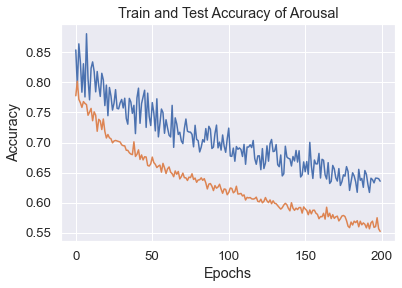

In [40]:
plt.plot(train_losses_ar);
plt.plot(test_losses_ar)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy of Arousal")

Text(0.5, 1.0, 'Train and Test Accuracy of Arousal')

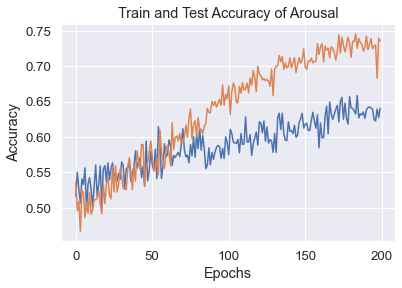

In [41]:
plt.plot(train_acc_arr_ar);
plt.plot(test_acc_arr_ar)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Train and Test Accuracy of Arousal")